In [7]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.tanh(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

In [11]:
import torch

class GaussianDiffusion:
    def __init__(self, timesteps=1000, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(0.0001, 0.02, timesteps).to(self.device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, axis=0).to(self.device)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0], device=self.device), self.alpha_cumprod[:-1]])
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas).to(self.device)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alpha_cumprod).to(self.device)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alpha_cumprod - 1).to(self.device)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_recip_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_start.shape)
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.gather(0, t).to(self.device)
        return out.view(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [12]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
diffusion = GaussianDiffusion(timesteps=1000, device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, _ = batch
        images = images.to(device)

        t = torch.randint(0, diffusion.timesteps, (images.size(0),), device=device).long()
        noise = torch.randn_like(images).to(device)
        noisy_images = diffusion.q_sample(images, t, noise)
        predicted_noise = model(noisy_images)

        loss = criterion(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

    # Save model checkpoint
    torch.save(model.state_dict(), f"unet_diffusion_epoch_{epoch+1}.pth")

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:22<00:00, 34.72it/s]


Epoch 1/100, Loss: 0.4318265253701783


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 48.00it/s]


Epoch 2/100, Loss: 0.28615847904511427


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.24it/s]


Epoch 3/100, Loss: 0.26791996827058473


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 40.89it/s]


Epoch 4/100, Loss: 0.2593021846907523


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 41.80it/s]


Epoch 5/100, Loss: 0.2529376780095003


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.13it/s]


Epoch 6/100, Loss: 0.24814197476333974


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.10it/s]


Epoch 7/100, Loss: 0.24437546291772058


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.39it/s]


Epoch 8/100, Loss: 0.24071241619870487


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.32it/s]


Epoch 9/100, Loss: 0.23757164429901811


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.17it/s]


Epoch 10/100, Loss: 0.23444290802149517


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.73it/s]


Epoch 11/100, Loss: 0.231896353918878


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 41.62it/s]


Epoch 12/100, Loss: 0.23010400002417358


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.78it/s]


Epoch 13/100, Loss: 0.22751999743606732


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.04it/s]


Epoch 14/100, Loss: 0.2251267104273867


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.53it/s]


Epoch 15/100, Loss: 0.2250759239734896


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.26it/s]


Epoch 16/100, Loss: 0.22336566722606455


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.35it/s]


Epoch 17/100, Loss: 0.22120250014545362


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.35it/s]


Epoch 18/100, Loss: 0.22071237703952032


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 41.46it/s]


Epoch 19/100, Loss: 0.22046024939212042


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.87it/s]


Epoch 20/100, Loss: 0.21921242095167984


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.05it/s]


Epoch 21/100, Loss: 0.2176984051990387


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 43.64it/s]


Epoch 22/100, Loss: 0.21579636419977982


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.09it/s]


Epoch 23/100, Loss: 0.2163456080057432


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.03it/s]


Epoch 24/100, Loss: 0.21545307726963706


Epoch 25/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 44.48it/s]


Epoch 25/100, Loss: 0.21499074785910605


Epoch 26/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.17it/s]


Epoch 26/100, Loss: 0.2146519419482297


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.23it/s]


Epoch 27/100, Loss: 0.21382964787352116


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.46it/s]


Epoch 28/100, Loss: 0.2133834317059773


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.50it/s]


Epoch 29/100, Loss: 0.2125962658230301


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.25it/s]


Epoch 30/100, Loss: 0.21249360326305985


Epoch 31/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 41.95it/s]


Epoch 31/100, Loss: 0.2110180466261971


Epoch 32/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.33it/s]


Epoch 32/100, Loss: 0.2115981167234728


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.10it/s]


Epoch 33/100, Loss: 0.21137256221012082


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.35it/s]


Epoch 34/100, Loss: 0.21109613128330396


Epoch 35/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.26it/s]


Epoch 35/100, Loss: 0.21005674988946035


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.23it/s]


Epoch 36/100, Loss: 0.2098622112475393


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.30it/s]


Epoch 37/100, Loss: 0.20981385320653695


Epoch 38/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.19it/s]


Epoch 38/100, Loss: 0.20953098697887967


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.96it/s]


Epoch 39/100, Loss: 0.2090418229208273


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.73it/s]


Epoch 40/100, Loss: 0.20941515806157265


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.33it/s]


Epoch 41/100, Loss: 0.20876224840159915


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.03it/s]


Epoch 42/100, Loss: 0.20875016245466974


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.17it/s]


Epoch 43/100, Loss: 0.20849764688164377


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.81it/s]


Epoch 44/100, Loss: 0.20848448231549518


Epoch 45/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 40.26it/s]


Epoch 45/100, Loss: 0.20723326771003206


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.02it/s]


Epoch 46/100, Loss: 0.2068449594937932


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.49it/s]


Epoch 47/100, Loss: 0.2071234255343142


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.95it/s]


Epoch 48/100, Loss: 0.20731140960893973


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.49it/s]


Epoch 49/100, Loss: 0.20604749829949015


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.73it/s]


Epoch 50/100, Loss: 0.20657878820701023


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.92it/s]


Epoch 51/100, Loss: 0.20659543718675824


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.55it/s]


Epoch 52/100, Loss: 0.20699020210281968


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.93it/s]


Epoch 53/100, Loss: 0.20573966458554158


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.33it/s]


Epoch 54/100, Loss: 0.20572369900124762


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.82it/s]


Epoch 55/100, Loss: 0.20582062873008


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.38it/s]


Epoch 56/100, Loss: 0.2051028354317331


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.48it/s]


Epoch 57/100, Loss: 0.2053503428997896


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.06it/s]


Epoch 58/100, Loss: 0.20527176905775923


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.93it/s]


Epoch 59/100, Loss: 0.20517000535031413


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 41.03it/s]


Epoch 60/100, Loss: 0.20442951565889447


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.99it/s]


Epoch 61/100, Loss: 0.20466978057189975


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 42.30it/s]


Epoch 62/100, Loss: 0.20448506543474734


Epoch 63/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.79it/s]


Epoch 63/100, Loss: 0.20478928952342104


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.15it/s]


Epoch 64/100, Loss: 0.20374989343802338


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.05it/s]


Epoch 65/100, Loss: 0.20375910826275112


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 40.76it/s]


Epoch 66/100, Loss: 0.20427207557289193


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.76it/s]


Epoch 67/100, Loss: 0.20414626827020474


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.32it/s]


Epoch 68/100, Loss: 0.20335198517726816


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.31it/s]


Epoch 69/100, Loss: 0.20317899336671585


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.12it/s]


Epoch 70/100, Loss: 0.2029507602076701


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.78it/s]


Epoch 71/100, Loss: 0.20316096561034316


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.29it/s]


Epoch 72/100, Loss: 0.20246945016676812


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 41.60it/s]


Epoch 73/100, Loss: 0.20271235540547333


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.64it/s]


Epoch 74/100, Loss: 0.20299923934442612


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.53it/s]


Epoch 75/100, Loss: 0.20293416385836613


Epoch 76/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 42.04it/s]


Epoch 76/100, Loss: 0.20235326634648512


Epoch 77/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.12it/s]


Epoch 77/100, Loss: 0.2025081644125302


Epoch 78/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.32it/s]


Epoch 78/100, Loss: 0.2022282256723365


Epoch 79/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.29it/s]


Epoch 79/100, Loss: 0.202638292994798


Epoch 80/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.09it/s]


Epoch 80/100, Loss: 0.20246468141408222


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.29it/s]


Epoch 81/100, Loss: 0.20135892382668108


Epoch 82/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.49it/s]


Epoch 82/100, Loss: 0.20170497219733266


Epoch 83/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.13it/s]


Epoch 83/100, Loss: 0.20123979014813748


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.06it/s]


Epoch 84/100, Loss: 0.2009678653172215


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.11it/s]


Epoch 85/100, Loss: 0.20178845208471693


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.25it/s]


Epoch 86/100, Loss: 0.20137651620999628


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.27it/s]


Epoch 87/100, Loss: 0.20095325671041103


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.91it/s]


Epoch 88/100, Loss: 0.20038152470841736


Epoch 89/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.54it/s]


Epoch 89/100, Loss: 0.2017032484264325


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.52it/s]


Epoch 90/100, Loss: 0.20122774469349392


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.22it/s]


Epoch 91/100, Loss: 0.20125978306659956


Epoch 92/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.36it/s]


Epoch 92/100, Loss: 0.2009321227288612


Epoch 93/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 43.94it/s]


Epoch 93/100, Loss: 0.2003903582768367


Epoch 94/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 42.94it/s]


Epoch 94/100, Loss: 0.20081197394205785


Epoch 95/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.23it/s]


Epoch 95/100, Loss: 0.20049767392446927


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.46it/s]


Epoch 96/100, Loss: 0.20045957838177986


Epoch 97/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.32it/s]


Epoch 97/100, Loss: 0.20005327209715953


Epoch 98/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.54it/s]


Epoch 98/100, Loss: 0.19975849725020206


Epoch 99/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.52it/s]


Epoch 99/100, Loss: 0.2002210813143369


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.36it/s]


Epoch 100/100, Loss: 0.20070625649160131


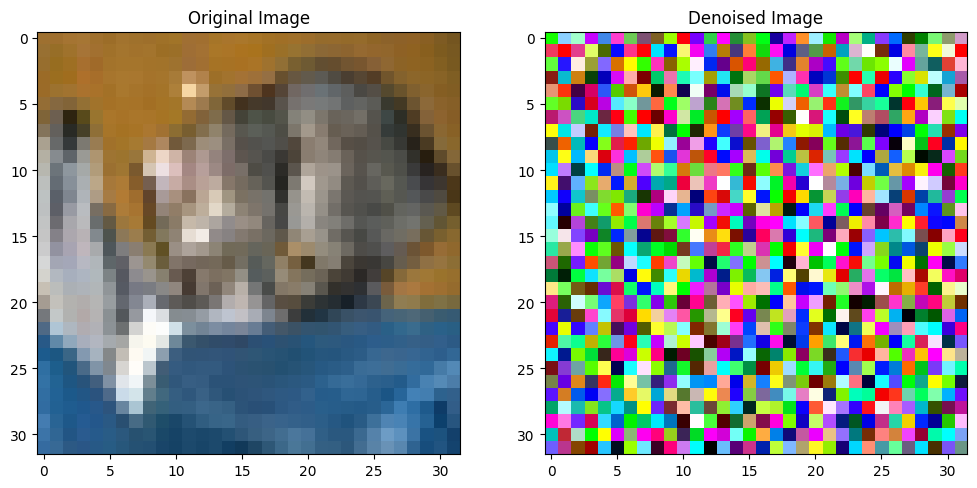

In [14]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, _ = batch
        images = images.to(device)

        t = torch.full((images.size(0),), diffusion.timesteps-1, device=device).long()
        noisy_images = diffusion.q_sample(images, t)
        denoised_images = model(noisy_images)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow((images[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1))
        axes[0].set_title("Original Image")
        axes[1].imshow((denoised_images[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1))
        axes[1].set_title("Denoised Image")
        plt.show()
        break

In [19]:
# Define and train Model 1 (Default Parameters)
model1 = UNet().to(device)
diffusion1 = GaussianDiffusion(timesteps=1000, device=device)
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
criterion1 = nn.MSELoss()

num_epochs = 50  # Reduced for demonstration
train_losses1 = []

for epoch in range(num_epochs):
    model1.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, _ = batch
        images = images.to(device)

        t = torch.randint(0, diffusion1.timesteps, (images.size(0),), device=device).long()
        noise = torch.randn_like(images).to(device)
        noisy_images = diffusion1.q_sample(images, t, noise)
        predicted_noise = model1(noisy_images)

        loss = criterion1(predicted_noise, noise)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        epoch_loss += loss.item()

    train_losses1.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses1[-1]}")

    # Save model checkpoint if needed
    # torch.save(model1.state_dict(), f"unet_diffusion_model1_epoch_{epoch+1}.pth")

Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 47.51it/s]


Epoch 1/50, Loss: 0.41680679464584114


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.82it/s]


Epoch 2/50, Loss: 0.28476546857210683


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.73it/s]


Epoch 3/50, Loss: 0.26784330684586866


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 41.32it/s]


Epoch 4/50, Loss: 0.2585092975622248


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 42.70it/s]


Epoch 5/50, Loss: 0.25418963127047817


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.68it/s]


Epoch 6/50, Loss: 0.24889506592088953


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.62it/s]


Epoch 7/50, Loss: 0.2439756356846646


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.82it/s]


Epoch 8/50, Loss: 0.2397660912226533


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.46it/s]


Epoch 9/50, Loss: 0.23607043986735138


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.79it/s]


Epoch 10/50, Loss: 0.23320746511373375


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.82it/s]


Epoch 11/50, Loss: 0.22964088399620616


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 40.25it/s]


Epoch 12/50, Loss: 0.22876563895007837


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.84it/s]


Epoch 13/50, Loss: 0.22548680708688848


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.51it/s]


Epoch 14/50, Loss: 0.22495174745235907


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.35it/s]


Epoch 15/50, Loss: 0.2236885499695073


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 40.57it/s]


Epoch 16/50, Loss: 0.22160119915862217


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.74it/s]


Epoch 17/50, Loss: 0.2202830141233971


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.63it/s]


Epoch 18/50, Loss: 0.21835908232747442


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 40.07it/s]


Epoch 19/50, Loss: 0.2190405850101005


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.89it/s]


Epoch 20/50, Loss: 0.21764088153381786


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.48it/s]


Epoch 21/50, Loss: 0.21641077808178294


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.22it/s]


Epoch 22/50, Loss: 0.2162485970446216


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.79it/s]


Epoch 23/50, Loss: 0.2153152449013632


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.79it/s]


Epoch 24/50, Loss: 0.21471637521710846


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.22it/s]


Epoch 25/50, Loss: 0.21403627131906006


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.56it/s]


Epoch 26/50, Loss: 0.21440738698710565


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.95it/s]


Epoch 27/50, Loss: 0.21317931990641767


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.57it/s]


Epoch 28/50, Loss: 0.21266727660165724


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.62it/s]


Epoch 29/50, Loss: 0.2114217793164046


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.14it/s]


Epoch 30/50, Loss: 0.21157774895124729


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.12it/s]


Epoch 31/50, Loss: 0.21081037847968317


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.46it/s]


Epoch 32/50, Loss: 0.21117920866783926


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.77it/s]


Epoch 33/50, Loss: 0.2107157470358302


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.87it/s]


Epoch 34/50, Loss: 0.2100673508270622


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.81it/s]


Epoch 35/50, Loss: 0.2098169480367085


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.01it/s]


Epoch 36/50, Loss: 0.20979788857500267


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.27it/s]


Epoch 37/50, Loss: 0.20886447494063537


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.02it/s]


Epoch 38/50, Loss: 0.2091875663575004


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.20it/s]


Epoch 39/50, Loss: 0.20898550346760494


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.82it/s]


Epoch 40/50, Loss: 0.20873508453750245


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.35it/s]


Epoch 41/50, Loss: 0.20869769552327178


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.72it/s]


Epoch 42/50, Loss: 0.20797783292620384


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.92it/s]


Epoch 43/50, Loss: 0.20749900459557238


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.84it/s]


Epoch 44/50, Loss: 0.20982505222949224


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.26it/s]


Epoch 45/50, Loss: 0.20689301467155252


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.89it/s]


Epoch 46/50, Loss: 0.2072265754308542


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.75it/s]


Epoch 47/50, Loss: 0.2073823681572819


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.66it/s]


Epoch 48/50, Loss: 0.20622866097694773


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.54it/s]


Epoch 49/50, Loss: 0.20670506078035325


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.27it/s]

Epoch 50/50, Loss: 0.20617912099946795


In [20]:
# Define and train Model 2 (Tuned Parameters)
model2 = UNet().to(device)
diffusion2 = GaussianDiffusion(timesteps=1000, device=device)
optimizer2 = optim.Adam(model2.parameters(), lr=5e-5)
criterion2 = nn.MSELoss()

num_epochs = 50  # Reduced for demonstration
train_losses2 = []

for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, _ = batch
        images = images.to(device)

        t = torch.randint(0, diffusion2.timesteps, (images.size(0),), device=device).long()
        noise = torch.randn_like(images).to(device)
        noisy_images = diffusion2.q_sample(images, t, noise)
        predicted_noise = model2(noisy_images)

        loss = criterion2(predicted_noise, noise)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        epoch_loss += loss.item()

    train_losses2.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses2[-1]}")

    # Save model checkpoint if needed
    # torch.save(model2.state_dict(), f"unet_diffusion_model2_epoch_{epoch+1}.pth")

Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.15it/s]


Epoch 1/50, Loss: 0.5159364782864481


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.07it/s]


Epoch 2/50, Loss: 0.3215250132029014


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.58it/s]


Epoch 3/50, Loss: 0.28953311668561243


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.65it/s]


Epoch 4/50, Loss: 0.27421204536162375


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.62it/s]


Epoch 5/50, Loss: 0.26476243561338586


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.45it/s]


Epoch 6/50, Loss: 0.2603713688261978


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.13it/s]


Epoch 7/50, Loss: 0.25562528236900145


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.90it/s]


Epoch 8/50, Loss: 0.2522867959173744


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.30it/s]


Epoch 9/50, Loss: 0.2490402796803533


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.95it/s]


Epoch 10/50, Loss: 0.24709193471371366


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.92it/s]


Epoch 11/50, Loss: 0.24516603463064984


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.96it/s]


Epoch 12/50, Loss: 0.24345174157406058


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.98it/s]


Epoch 13/50, Loss: 0.24181036445338402


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.03it/s]


Epoch 14/50, Loss: 0.23989058501275298


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.00it/s]


Epoch 15/50, Loss: 0.23857935047363077


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.77it/s]


Epoch 16/50, Loss: 0.23761269646456173


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.94it/s]


Epoch 17/50, Loss: 0.23635452791400577


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.89it/s]


Epoch 18/50, Loss: 0.2359080049769043


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.76it/s]


Epoch 19/50, Loss: 0.23474992110448725


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.77it/s]


Epoch 20/50, Loss: 0.23404130009967652


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.83it/s]


Epoch 21/50, Loss: 0.23433326954579414


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.08it/s]


Epoch 22/50, Loss: 0.23281787644566782


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.00it/s]


Epoch 23/50, Loss: 0.2324750679152091


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.91it/s]


Epoch 24/50, Loss: 0.23133836825714088


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.08it/s]


Epoch 25/50, Loss: 0.2302955595200019


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.88it/s]


Epoch 26/50, Loss: 0.2313254630321737


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 37.61it/s]


Epoch 27/50, Loss: 0.2301482438964917


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 37.92it/s]


Epoch 28/50, Loss: 0.22980056847910138


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.92it/s]


Epoch 29/50, Loss: 0.22874274611701745


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.69it/s]


Epoch 30/50, Loss: 0.228372465237937


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.89it/s]


Epoch 31/50, Loss: 0.22830612423932156


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.65it/s]


Epoch 32/50, Loss: 0.2285180894272102


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.72it/s]


Epoch 33/50, Loss: 0.2280288146013189


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.50it/s]


Epoch 34/50, Loss: 0.22720756898145847


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.79it/s]


Epoch 35/50, Loss: 0.22658420664727535


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.32it/s]


Epoch 36/50, Loss: 0.2259878915784609


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.75it/s]


Epoch 37/50, Loss: 0.2265729523070938


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.13it/s]


Epoch 38/50, Loss: 0.22572281417410697


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.20it/s]


Epoch 39/50, Loss: 0.22593537967680666


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.15it/s]


Epoch 40/50, Loss: 0.22456770777092566


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.03it/s]


Epoch 41/50, Loss: 0.2240376620531997


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.89it/s]


Epoch 42/50, Loss: 0.22464208706946628


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.85it/s]


Epoch 43/50, Loss: 0.22382471030173096


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.64it/s]


Epoch 44/50, Loss: 0.22454688793329328


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.38it/s]


Epoch 45/50, Loss: 0.22305714920201264


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 44.28it/s]


Epoch 46/50, Loss: 0.2227877452969551


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.86it/s]


Epoch 47/50, Loss: 0.22269644496767113


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 38.84it/s]


Epoch 48/50, Loss: 0.22189678890092293


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:20<00:00, 39.03it/s]


Epoch 49/50, Loss: 0.2220738866864263


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 40.50it/s]

Epoch 50/50, Loss: 0.2227686182464785


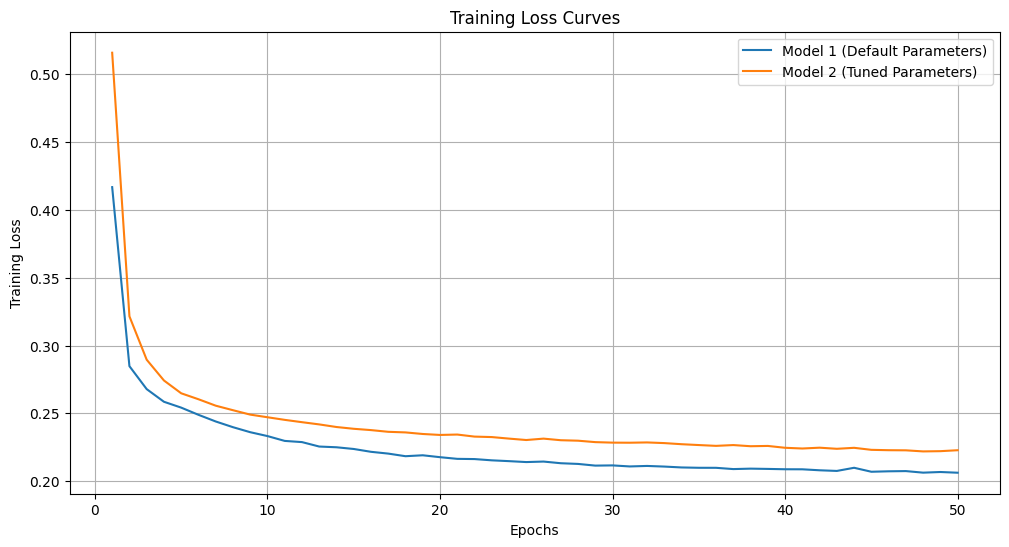

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses1, label='Model 1 (Default Parameters)')
plt.plot(epochs, train_losses2, label='Model 2 (Tuned Parameters)')
plt.title('Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

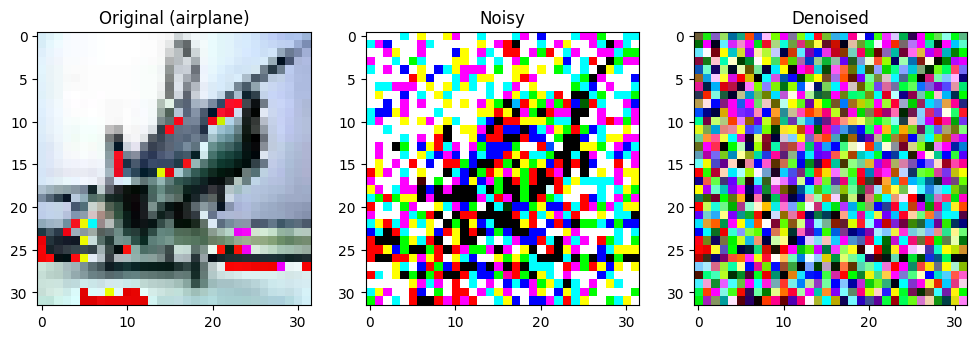

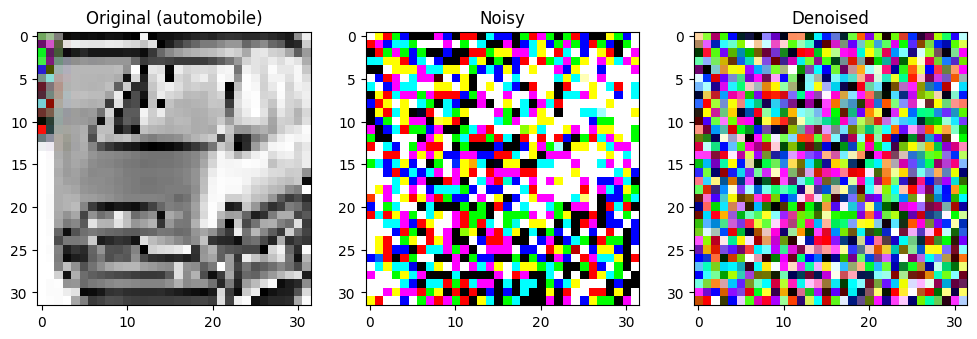

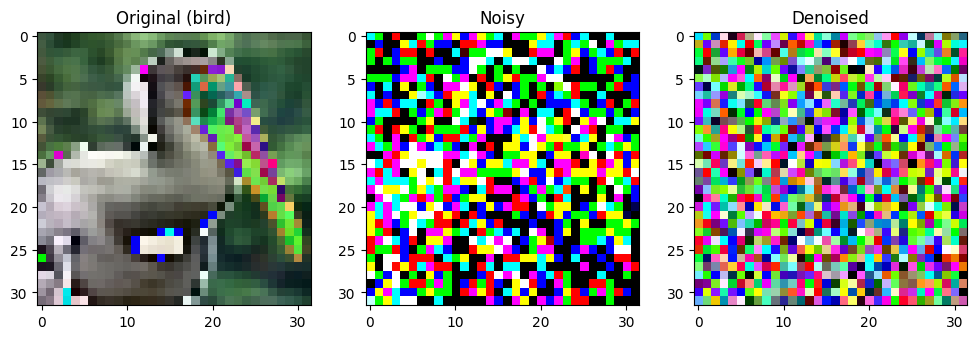

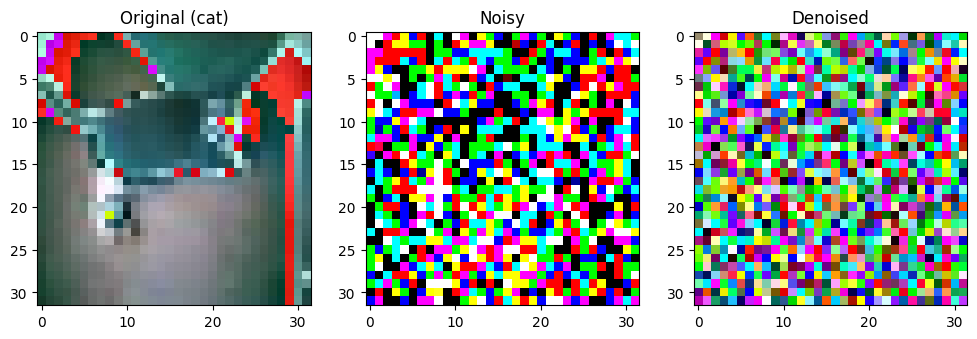

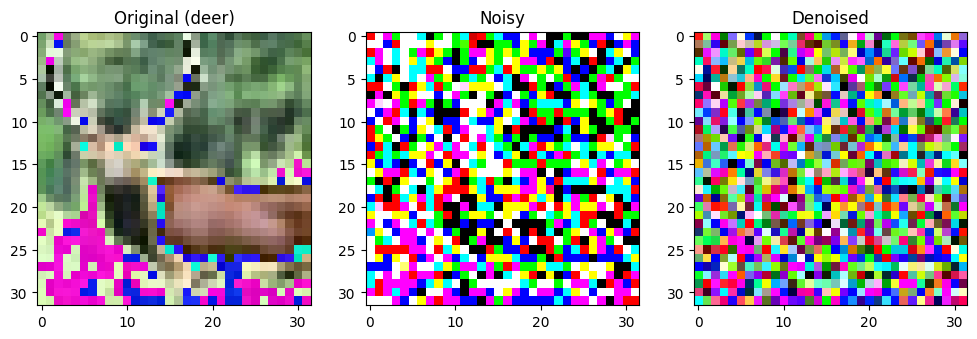

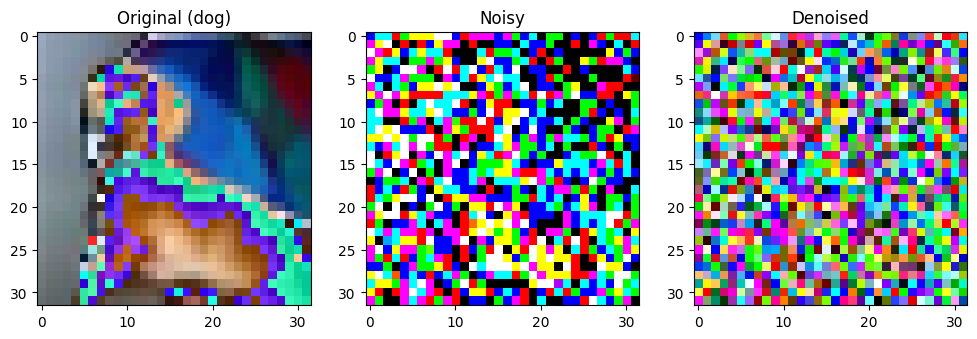

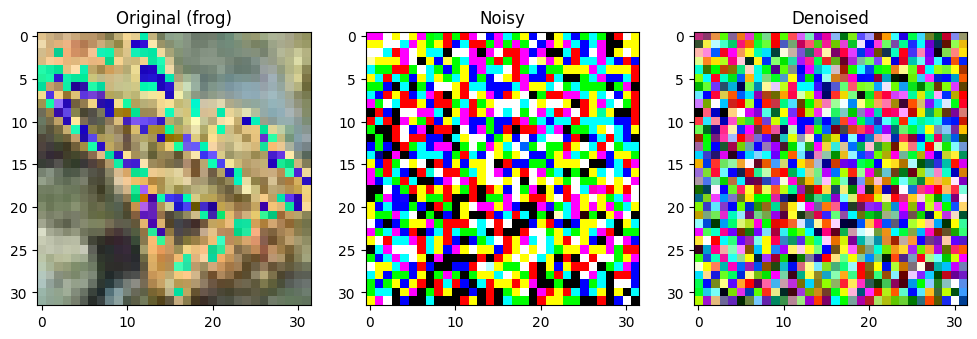

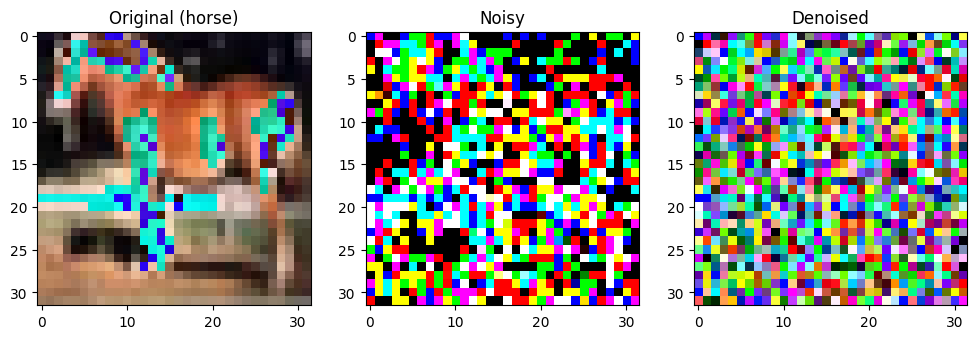

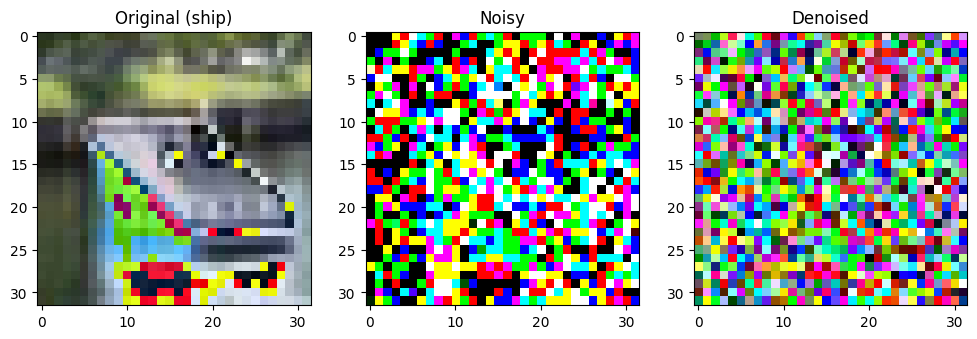

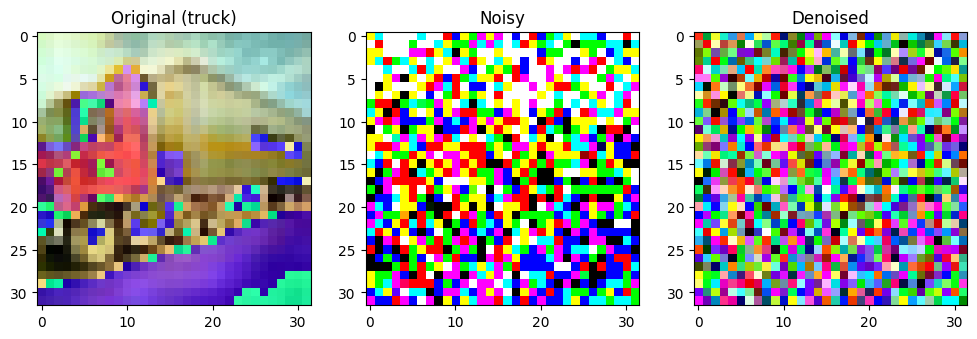

In [24]:
import torchvision.transforms as transforms
from PIL import Image
import random
import matplotlib.pyplot as plt

# Define the transform to convert tensor to PIL image and back to tensor with normalization
tensor_to_pil = transforms.ToPILImage()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Function to generate and visualize samples from each class
def generate_samples_from_classes(model, diffusion, device, test_dataset, class_names):
    model.eval()
    with torch.no_grad():
        for class_idx in range(10):
            # Find a random image from this class
            class_images = [img for img, label in test_dataset if label == class_idx]
            img = random.choice(class_images)

            # Convert the tensor to PIL image, and then back to tensor after applying transformations
            img = tensor_to_pil(img)
            img = transform(img).unsqueeze(0).to(device)

            # Generate denoised image
            t = torch.full((1,), diffusion.timesteps - 1, device=device).long()
            noisy_img = diffusion.q_sample(img, t)
            denoised_img = model(noisy_img)

            # Convert tensors to numpy arrays for visualization
            img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            noisy_img = noisy_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            denoised_img = denoised_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)

            # Plot original, noisy, and denoised images
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow((img * 0.5 + 0.5).clip(0, 1))
            axes[0].set_title(f"Original ({class_names[class_idx]})")
            axes[1].imshow((noisy_img * 0.5 + 0.5).clip(0, 1))
            axes[1].set_title("Noisy")
            axes[2].imshow((denoised_img * 0.5 + 0.5).clip(0, 1))
            axes[2].set_title("Denoised")
            plt.show()

# Call the function with appropriate parameters
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
generate_samples_from_classes(model, diffusion, device, test_dataset, class_names)